
#Assignment-#02
###Stereo Depth Estimation Using SIFT. Complete each question by implementing the required functions and code cells, following the instructions provided.



### Import Libraries


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Define Camera Parameters

In [2]:
#Given the focal length and baseline
focal_length = 4152.073   # in pixels
baseline =  176.252       # in mm or the same unit

### Load Stereo Images

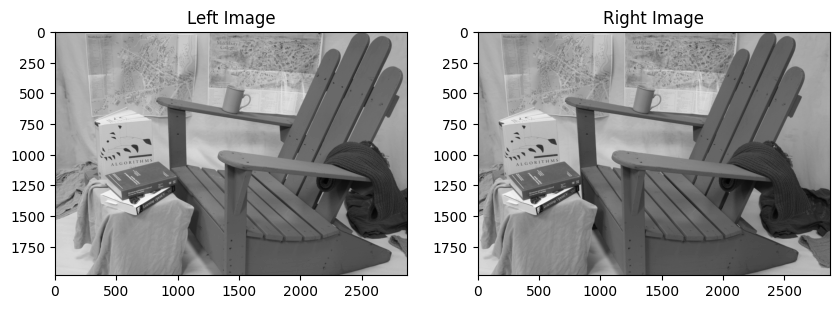

In [5]:
# Load left and right images
left_image = cv2.imread('C:/Users/M2-Winterfell/Downloads/Computer Vision/Assignment-2/Images/im0.png', cv2.IMREAD_GRAYSCALE)
right_image = cv2.imread('C:/Users/M2-Winterfell/Downloads/Computer Vision/Assignment-2/Images/im1.png', cv2.IMREAD_GRAYSCALE)

if left_image is None or right_image is None:
    raise ValueError("Images not found! Make sure 'left_image.jpg' and 'right_image.jpg' are in the same directory.")

# Display images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1), plt.imshow(left_image, cmap='gray'), plt.title("Left Image")
plt.subplot(1, 2, 2), plt.imshow(right_image, cmap='gray'), plt.title("Right Image")
plt.show()

### Describe the differences you observe in the left and right images (2 Points)

1. The yellow cup's position: In the first image, the yellow cup is placed on the armrest of the chair towards the back. In the second image, it has been moved slightly forward on the armrest.
2. The yellow scarf's position. In the first image, the yellow scarf is barely seen in the bottom right corner. In the second image, it has been moved slightly to the left so that people can see a larger part of the yellow scarf.

### Write a function to detects and matches SIFT features between two images using FLANN-based matcher and Lowe's ratio test.  (3 Points)

In [6]:
def detect_and_match_features(left_image, right_image, ratio_test_threshold=0.7):
    """
    Detects and matches SIFT features between two images using FLANN-based matcher and Lowe's ratio test.

    Parameters:
    - left_image: Left image in stereo pair (grayscale).
    - right_image: Right image in stereo pair (grayscale).
    - ratio_test_threshold: Threshold for Lowe's ratio test to filter matches (default=0.7).

    Returns:
    - good_matches: List of good matches that passed the ratio test.
    - keypoints_left: Keypoints in the left image.
    - keypoints_right: Keypoints in the right image.
    - matched_image: Image showing matches between left and right images.
    """

    # Step 1: Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Step 2: Detect and compute keypoints and descriptors
    keypoints_left, descriptors_left = sift.detectAndCompute(left_image, None)
    keypoints_right, descriptors_right = sift.detectAndCompute(right_image, None)

    # Step 3: Use FLANN-based matcher

    # This sets the algorithm to KD-Tree, which suitable for SIFT
    FLANN_INDEX_KDTREE = 1

    # algorithm = 1 specifies using KD-Tree algorithm and trees = 5 sets the number of trees in index
    # More trees increase accuracy but require more computational resources.
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)

    # The checks parameter specifies the number of times the trees will be traversed when serching for nearest neighbour
    # A higher checks value reslts in better accuracy but is slower;
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors_left, descriptors_right, k=2)

    # Step 4: Apply Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < ratio_test_threshold * n.distance:
            good_matches.append(m)

    # Step 5: Draw matches for visualization
    matched_image = cv2.drawMatches(left_image, keypoints_left, right_image, keypoints_right, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    return good_matches, keypoints_left, keypoints_right, matched_image


Sample x-coordinates in left image (xL): ['58.03', '59.72', '62.04', '62.77', '63.42', '65.50', '69.33', '70.82', '72.10', '91.17']
Sample x-coordinates in right image (xR): ['12.62', '14.11', '17.06', '17.04', '18.59', '20.28', '24.53', '26.11', '25.61', '45.60']


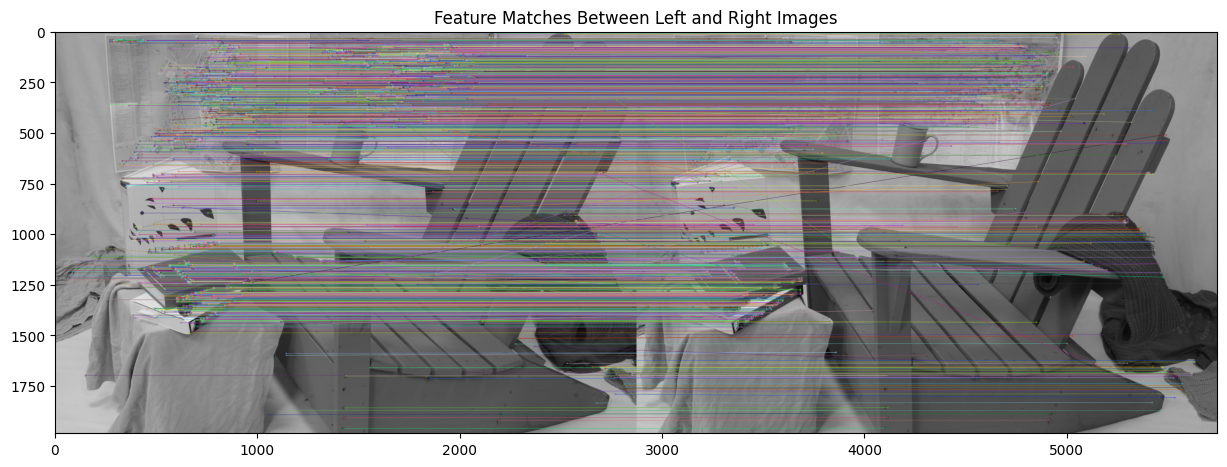

In [9]:
good_matches, keypoints_left, keypoints_right, matched_image = detect_and_match_features(left_image, right_image)

# Extract the x-coordinates of the keypoints from the matches and format to 2 decimal places
xl_coords = [f"{keypoints_left[match.queryIdx].pt[0]:.2f}" for match in good_matches[:10]]
xr_coords = [f"{keypoints_right[match.trainIdx].pt[0]:.2f}" for match in good_matches[:10]]

# Print x-coordinates
print("Sample x-coordinates in left image (xL):", xl_coords)
print("Sample x-coordinates in right image (xR):", xr_coords)

# Display the matched image
plt.figure(figsize=(15, 10))
plt.imshow(matched_image)
plt.title("Feature Matches Between Left and Right Images")
plt.show()


###  Write a function to calculates the disparity between matched keypoints in left and right images. (3 Points)

In [10]:
def calculate_disparity(keypoints_left, keypoints_right, good_matches, doffs=0):
    """
    Calculates the disparity between matched keypoints in left and right images.

    Parameters:
    - keypoints_left: Keypoints from the left image.
    - keypoints_right: Keypoints from the right image.
    - good_matches: List of good matches from feature matching.
    - doffs: Disparity offset (default is 0).

    Returns:
    - disparities: List of disparities for each matched keypoint pair.
    - xl_coords: List of x-coordinates in the left image for each matched keypoint pair.
    - xr_coords: List of x-coordinates in the right image for each matched keypoint pair.
    """

    # Initialize lists to store x-coordinates and disparities
    xl_coords = []
    xr_coords = []
    disparities = []

    # Loop through each good match and calculate disparity
    for match in good_matches:
        # Get the x-coordinates of the matched keypoints
        xL = keypoints_left[match.queryIdx].pt[0]
        xR = keypoints_right[match.trainIdx].pt[0]

        # Append x-coordinates
        xl_coords.append(xL)
        xr_coords.append(xR)

        # Calculate disparity (xL - xR + doffs)
        disparity = xL - (xR + doffs)
        disparities.append(disparity)

    return disparities, xl_coords, xr_coords


 ### Display the disparity map

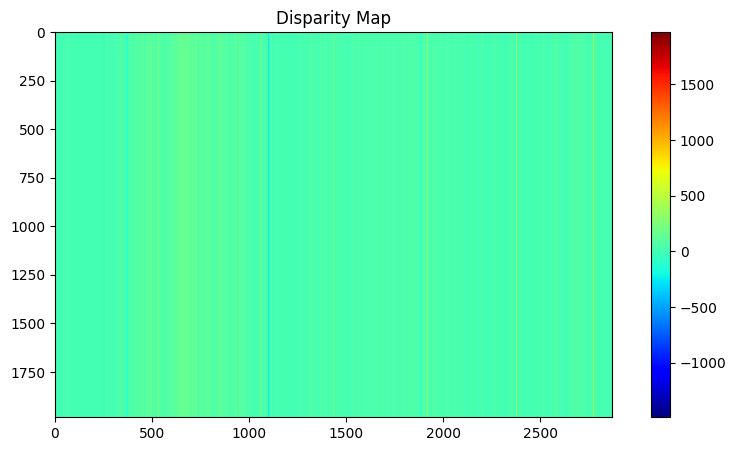

In [12]:

disparities, xl_coords, xr_coords = calculate_disparity(keypoints_left, keypoints_right, good_matches)

# Generate a disparity map using the left image's dimensions
disparity_map = np.zeros_like(left_image, dtype=np.float32)

# Populate the map using both xl and xr coordinates to ensure the disparity aligns across the width
for xL, xR, disparity in zip(xl_coords, xr_coords, disparities):
    # Ensure xL and xR are within bounds
    xL, xR = int(xL), int(xR)
    if 0 <= xL < disparity_map.shape[1] and 0 <= xR < disparity_map.shape[1]:
        disparity_map[:, int(xL)] = disparity

# Display the disparity map
plt.figure(figsize=(10, 5))
plt.imshow(disparity_map, cmap='jet')
plt.colorbar()
plt.title("Disparity Map")
plt.show()

### Write a function to calculates the depth map from a given disparity map, focal length, and baseline  (3 Points)

In [17]:
def calculate_depth_map(disparity_map, focal_length, baseline):
    """
    Calculates the depth map from a given disparity map, focal length, and baseline.

    Parameters:
    - disparity_map: 2D numpy array of disparities (same dimensions as the input images).
    - focal_length: Focal length of the camera in pixels.
    - baseline: Distance between the two camera centers in the stereo setup (in the same units as focal length).

    Returns:
    - depth_map: 2D numpy array representing depth for each pixel (same dimensions as disparity_map).
    """
    # Calculate depth map using the formula Z = (focal_length * baseline) / disparity
    depth_map = (focal_length * baseline) / disparity_map

    return depth_map


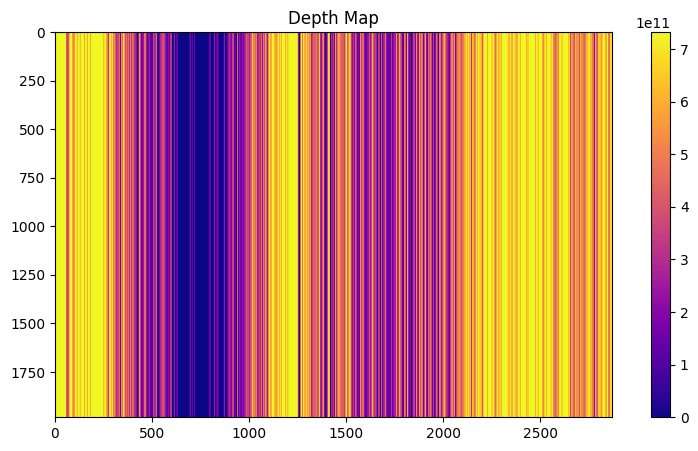

In [18]:
depth_map = calculate_depth_map(disparity_map, focal_length, baseline)

# Display the depth map
plt.figure(figsize=(10, 5))
plt.imshow(depth_map, cmap='plasma')
plt.colorbar()
plt.title("Depth Map")
plt.show()

###  Disparity Map Analysis: What does the disparity map represent? How does it relate to depth perception? Write the Mathematical Relationship (2 Points)

1. The disparity map represents the pixel-wise horizontal displacement between corresponding points in the left and right images of a camera pair in same height. Each value in the disparity map corresponds to the difference in the x-coordinates of a point’s projection on the left and right image planes. Disparity is highest for objects close to the camera and decreases for objects farther away.
2. The disparity map serves as an intermediate step in determining the depth map

3. How disparity relates to depth perception: Inverse Relationship: Disparity and depth have an interse relationship, where larger disparities correspond to closer objects (smaller Z values), and smaller disparities correspond to farther objects (larger Z values)

4. To calculate the depth map, we’ll use the formula derived from stereo vision geometry. Depth Z can be calculated from the disparity d using the following relationship:
- Z = (f * B) / d
    - Z is the depth value at each pixel
    - f is the focal length of the camera
    - B is the baseline (distance between two cameras)
    - d is the disparity at each pixel
    - if xl and xr are the x-coordinates of the projections in left and right images, then disparity d = | xl - xr |